## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
conv_users = df.query('converted == 1')['user_id'].nunique()
total_users = df.shape[0]
conv_users_proportion= conv_users / total_users
print(conv_users_proportion)

0.1194418598333322


e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
#Find mismatched group and landing page
mis_matches = df.query('(group == "control" and landing_page == "new_page") or (group == "treatment" and landing_page == "old_page")').count()[0]
mis_matches

3893

f. Do any of the rows have missing values?

In [8]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
#drop rows mismatched rows
df2 = df.drop(df.query('(group == "control" and landing_page == "new_page") or (group == "treatment" and landing_page == "old_page")').index)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
duplicated_user = df2[df2.duplicated(['user_id'], keep=False)]['user_id']
duplicated_user

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
duplicated_user_info = df2[df2['user_id'] == 773192]
duplicated_user_info

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
# Drop the duplicated user
df2 = df2.drop_duplicates(subset='user_id', keep='first')

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2[df2['group'] == "control"]['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2[df2['group'] == "treatment"]['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
(df2['landing_page'] == "new_page").mean()

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

>From the results in (d) above we see the that the probability of an individual receiving an old or new page is **~0.5** each meaning we have almost same amount of users testing each of the pages. The probability of  a conversion ; regardless of the page given is **0.1196**, given the group is "control" is **0.1204** and given the group is "treatment" is **0.1188**. I think this difference among them is too small in determining the new treatment page leads to more conversion. Hence there is no evidence in supporting this.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

> Null Hypothesis (**$H_{O}$** ) : **$p_{new}$** - **$p_{old}$** <= 1

> Alternative Hypothesis (**$H_{1}$** ) : **$p_{new}$** - **$p_{old}$** > 1 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
# new page convert rate
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
#old page convert rate
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
# number of new landing page
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()
n_new

145310

d. What is $n_{old}$?

In [22]:
# number of old landing page
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
# binomial distribution for converted users usng new_page
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
# binomial distribution for converted users usng old_page
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted

array([0, 1, 0, ..., 0, 0, 0])

g. Find **$p_{new}$** - **$p_{old}$** for your simulated values from part (e) and (f).

In [25]:
ps_diff = new_page_converted.mean() - old_page_converted.mean()
ps_diff

-0.000249737124737498

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    old_page_converted = np.random.binomial(1, p_old, n_old)
    diffs = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diffs)   

#Change the array into a numpy array
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  13.,   81.,  380., 1340., 2525., 2780., 1932.,  736.,  186.,
          27.]),
 array([-0.00465469, -0.00376476, -0.00287483, -0.0019849 , -0.00109497,
        -0.00020504,  0.00068489,  0.00157482,  0.00246475,  0.00335468,
         0.00424461]),
 <a list of 10 Patch objects>)

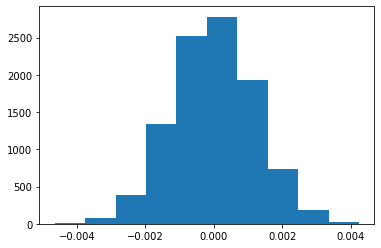

In [27]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
# Users in the old and new pages
new_conv_users = df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()
old_conv_users = df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()

In [29]:
#Actual Covert Rate
act_old_conv_users = old_conv_users / n_old
act_new_conv_users = new_conv_users / n_new

act_old_conv_users, act_new_conv_users

(0.1203863045004612, 0.11880806551510564)

In [30]:
#observable difference
obsv_diff = act_new_conv_users - act_old_conv_users
obsv_diff

-0.0015782389853555567

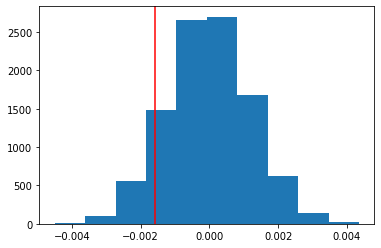

In [31]:
#Create a distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

#Corresponding histogram
plt.hist(null_vals)

# The actual diff
plt.axvline(obsv_diff, c="red")

In [32]:
#Calculate the p-value
p_val = (null_vals > obsv_diff).mean()
p_val

0.9034

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

>The value calculated above is called the p_value. Our type one threshold is 5% that is **0.05** and our calculated p-value is **0.904**. This clealy shows that our the p-value is greater that the threshold meaning that our statistics was more likely to come from the null hypothesis. We therefore have evidence to reject the null hypothesis and we therefore fail to reject the null hypothesis. This means from our analysis, we observe that The old page generates more or equal converts as the new page does.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [34]:
import statsmodels.api as sm

convert_old = sum(df2.query('group == "control"')['converted'])
convert_new = sum(df2.query('group == "treatment"')['converted'])
n_old = df.query('landing_page == "old_page"').shape[0]
n_new = df.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [35]:
#finding z-score and p-value
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old ], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.2851562063649145, 0.9006311481555165)

In [36]:
from scipy.stats import norm

# Significance of the z score
z_cdf = norm.cdf(z_score)
print("The cdf is : {}".format(z_cdf))

#Critical value at 95% confidence level
critical_val = norm.ppf(1-(0.05/2))
print("The ppf is : {}".format(critical_val))

The cdf is : 0.09936885184448352
The ppf is : 1.959963984540054


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>The z score **-1.2852** is and p-value is **0.9006**. Computing the critical value of z-score at 95% is significant in enabling us to decide whether reject or fail to reject he null hytpothesis. From the results this value is **~1.96**. Our z-score is between the 95% confidence level of between **-1.96** and **+1.96**. In addition to this and the value of our p-value being greater than 0.05, we therefore can come to a conclusion of failing to reject the null. This findings are the same as in parts **j** and **k**.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

>Since we want to predict categorical response that is either __conversion__ or __no conversion__, the appropriate regression methos to use will be __Logistic regression__.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
#Add intercept
df2['intercept'] = 1

#Get dummies for landing page
df2 = df2.join(pd.get_dummies(df['landing_page']))

#Get dummies for groups
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']

In [38]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [39]:
#Fitting the model
log_val = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_val.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
#Summary of the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 19 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        06:23:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value is **0.19** and the p-value in the **Part II** is **~0.9**

> In **Part II** the null and alternative hypothesis are as follows:

   Null Hypothesis (**$H_{O}$** ) : **$p_{new}$** - **$p_{old}$** <= 1
   
   Alternative Hypothesis (**$H_{1}$** ) : **$p_{new}$** - **$p_{old}$** 
   
> The computation we did in the logical model takes the null and alternative as:

   Null Hypothesis (**$H_{O}$** ) : **$p_{new}$** = **$p_{old}$** <= 1
    
   Alternative Hypothesis (**$H_{1}$** ) : **$p_{new}$** != **$p_{old}$**  
    
Having difference in the null and alternative hypotheses in **Part II** and **Part III** is what bring about the difference in p-values

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> There are some factors we have not consider in our analysis, that is timeframe and country. These may be very key factors to consider. For example we dont know haow long the users have been using the various pages therefore we dont know if its long enough for them to decide whether to convert or not. There is also the country factor which can influence where a user converts or not.

> The clusion of additional variable can have its effect for example, it can make some variable which were not statistically significant, to be statistically significant.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [41]:
# read countries.csv
countries_df = pd.read_csv('./countries.csv')

#join the new df with our existing one
df_new = df2.merge(countries_df, on = 'user_id', how='left')
df_new.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,1,0,US
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,1,CA
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,1,0,US
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1,UK
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,1,CA


In [42]:
### Create the necessary dummy variables
df_new[['CA','US','UK']] = pd.get_dummies(df_new['country'])
df_new = df_new.drop('CA', axis=1)
df_new.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,US,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,1,0,US,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,1,CA,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,1,0,US,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1,UK,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,1,CA,0,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 19 Jul 2020   Pseudo R-squ.:               2.323e-05
Time:                        06:23:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0506      0.028      1.784      0.074      -0.005       0.106
UK             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [44]:
np.exp(results.params)

intercept    0.131332
ab_page      0.985168
US           1.051944
UK           1.041599
dtype: float64

In [45]:
# Find reciprical
1/0.985168

1.0150553002127556

> Interpretation
For every one unit descrease in ab_page, there is 1.02% likelyhood that a convert will happen, holding all other variable constant.
For every one unit increase in US, there is 1.05% likelyhood that a convert will happen, holding all other variable constant.
For every one unit descrease UK, there is 1.04% likelyhood that a convert will happen, holding all other variable constant.

In [46]:
#Create interaction variable for ab_page and UK / US
df_new['ab_UK'] = df_new['ab_page'] * df_new['UK']
df_new['ab_US'] = df_new['ab_page'] * df_new['US']

In [47]:
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,US,UK,ab_UK,ab_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US,0,1,0,0


In [48]:
### Fit Your Linear Model And Obtain the Results
log_mod2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK','ab_UK','ab_US']])
results2 = log_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 19 Jul 2020   Pseudo R-squ.:               3.482e-05
Time:                        06:23:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0118      0.040      0.296      0.767      -0.066       0.090
UK             0.0175      0.038      0.465      0.642      -0.056       0.091
ab_UK          0.0469      0.054      0.872      0.383      -0.059       0.152
ab_US          0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

In [49]:
# Find exponential of the parameters
np.exp(results2.params)

intercept    0.134794
ab_page      0.934776
US           1.011854
UK           1.017682
ab_UK        1.048001
ab_US        1.081428
dtype: float64

In [50]:
#Calculate the reciprocol of ab_page as it's exponent is less than 1
1/0.934776

1.069775004920965

>For every one unit descrease in ab_page, there is 1.07% likelyhood that a convert will happen, holding all other variable constant.
For users in US, a user is 1.08% likely to convert than the one in CA, holding all variable constant.
For users in UK, a user is 1.05% likely to convert than the one in CA, holding all variable constant.

> From the above analysis, it seems that the countries that seem to have more conversions are UK, US and CA respectively. However countries does not seem to affect conversion as the difference is too small.

# <a id='conclusions'></a>
## Conclusions
After the analysis done in different methods that is; Sampling distribution, using z-index and using logical regression we have enough evidence to fail to reject the null. That means that the new page does not generate more conversions that the old. It generates less or almost the same as the new page. My recommendation therefore is not to change to the new page but to keep the old one.
 

## Resources

[Pandas Documentation]("https://pandas.pydata.org/docs/user_guide/")

[Numpy Documentation]("https://numpy.org/doc/stable/user/")

[Matplotlib Documentation]("https://matplotlib.org/3.2.1/tutorials/index.html")

[Seaborn Documentation]("https://seaborn.pydata.org/tutorial.html")

[Github]("https://github.com/Alicelibinguo/Analyzing-Website-Landing-Page-A-B-Test-Results-/blob/master/Analyze_ab_test_results_notebook.py")
[Z-index]("http://resources.esri.com/help/9.3/arcgisengine/java/gp_toolref/spatial_statistics_toolbox/what_is_a_z_score_what_is_a_p_value.htm")

